In [1]:
import pandas as pd
import numpy as np 
import statsmodels.api as sm 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')


from scipy.stats import norm 
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [6]:
data=[]

with open('/Users/withmocha/Downloads/concentration.txt') as f:
    lines=f.readlines()
    for line in lines:
        line=line.split(' ')
        line[len(line)-1] = line[len(line)-1].replace('\n', '')
        line = line[1:]
        data += [x for x in line if x]

data=[float(x) for x in data]

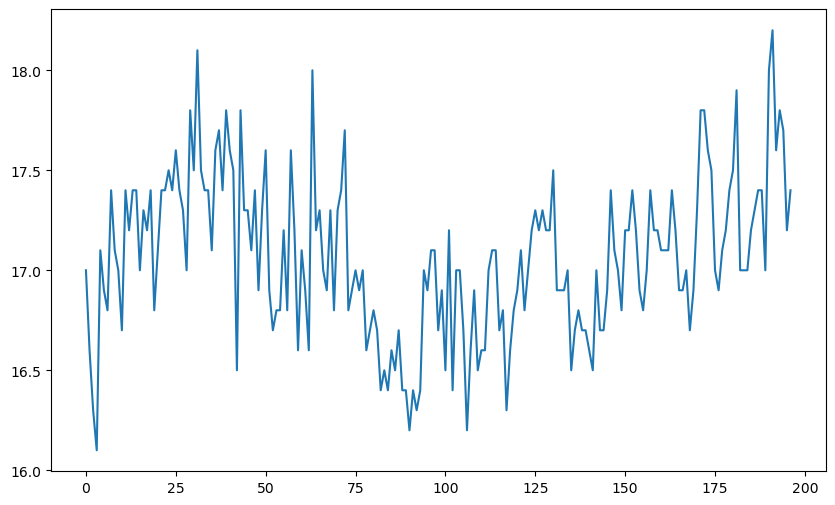

In [7]:
fig=plt.figure(figsize=(10,6))
fig.set_facecolor('white')
plt.plot(range(len(data)),data)
plt.show()

In [8]:
def esacf(data, ar_max=7, ma_max = 13, alpha=0.05, symbol=True):
    sig = norm.ppf(1-alpha/2)
    def lag_function(data, lag=1):
        res = [np.nan]*lag + list(data[:-lag])
        res = np.array(res)
        return res
 
    def ar_ols(data, ar_order):
        depedent_data = np.array(data[ar_order:])
        X = np.empty((0,ar_order))
        for i in range(ar_order,len(data)):
            temp_row = data[i-ar_order:i][::-1]
            X = np.vstack([X, temp_row])
 
        model = sm.OLS(depedent_data,X)
        results = model.fit()
        return results.params
 
    def reupm(mat, ncol):
        k = ncol-1
        nrow = mat.shape[0]
        # mat2[:] = np.nan
        for i in range(k):
            i1 = i+1
            work = lag_function(mat[:,i])
            work[0] = -1
            temp = mat[:,i1] - (mat[i1,i1]/mat[i,i])*work
            temp[i1] = 0
            if i ==0:
                mat2 = np.expand_dims(temp, axis=1)
            else:
                mat2 = np.column_stack((mat2, temp))
        return mat2
 
    ar_max += 1
    ma_max += 1
    nar = ar_max-1
    nma = ma_max
    ncov = nar + nma + 2
    nrow = nar + nma + 1
    ncol = nrow - 1
 
    def ceascf(m, cov1, nar, ncol, count, ncov, z, zm):
        result = [0]*(nar+1)
        result[0] = cov1[ncov+count]
        for i in range(nar):
            temp = np.column_stack((z[i+1:], zm[i+1:,:i+1])).dot([1]+list(-mat2[:i+1, i]))
            result[i+1] = acf(temp, nlags=count+1, fft=False)[count+1]
        return result
    
    z = data-np.mean(data)
    for i in range(nar):
        if i == 0:
            zm = np.expand_dims(lag_function(z,i+1), axis=1)
        else:
            zm = np.column_stack((zm,lag_function(z,i+1)))
 
    cov1 = acf(z, nlags=ncov, fft=False)
    cov1 = np.array(list(cov1[1:][::-1]) + list(cov1))
    ncov += 1
    mat = np.zeros((nrow,ncol))
    for i in range(ncol):
        mat[:i+1,i] = ar_ols(z, ar_order=i+1)
 
    for i in range(nma):
        mat2 = reupm(mat, ncol)
        ncol = ncol - 1
        if i == 0:
            eacfm = np.expand_dims(ceascf(mat2, cov1, nar, ncol, i, ncov, z, zm),axis=1)
        else:
            eacfm = np.column_stack((eacfm,ceascf(mat2, cov1, nar, ncol, i, ncov, z, zm)))
        mat = mat2
    
    if symbol:
        work = len(z) - np.array(range(1, nar+2))+1
        for j in range(nma):
            work = work - 1
            temp = np.abs(eacfm[:,j]) > sig/np.sqrt(work)
            temp = np.array(['X' if t else 'O' for t in temp])
            if j == 0:
                symbol = np.expand_dims(temp, axis=1)
            else:
                symbol = np.column_stack((symbol, temp))
        return pd.DataFrame(symbol)
    else:
        return pd.DataFrame(eacfm)


In [9]:
esacf(data,ar_max=5,ma_max=8,alpha=0.01,symbol=True)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,0,1,2,3,4,5,6,7,8
0,X,X,X,X,X,X,X,X,X
1,X,O,O,O,O,O,O,O,O
2,X,X,O,O,O,O,O,O,O
3,X,O,O,O,O,O,O,O,O
4,X,O,O,O,O,O,O,O,O
5,X,X,O,O,O,O,O,O,O


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


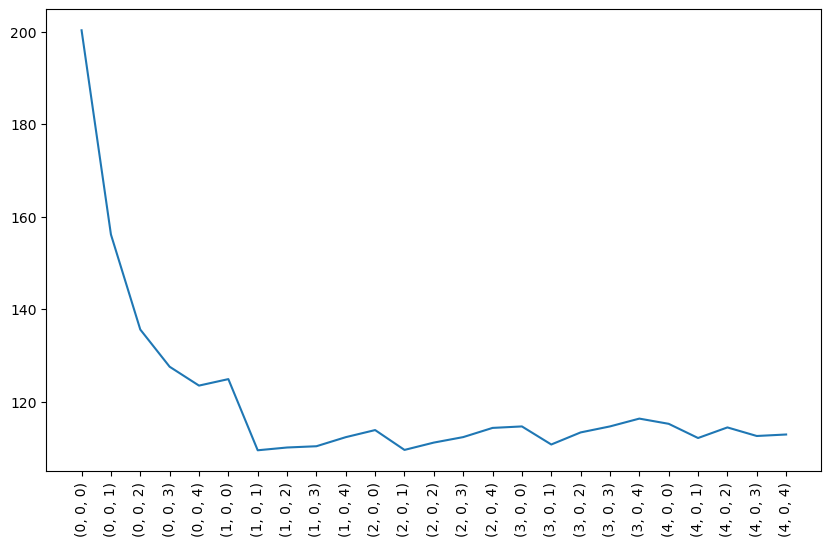

In [10]:
ar_max=4
ma_max=4
aic_val=[]
order_list=[]
for ar in range(ar_max+1):
    for ma in range(ma_max+1):
        order=(ar,0,ma)
        order_list.append(str(order))
        model=ARIMA(data,order=order).fit()
        aic_val.append(model.aic)
        
fig = plt.figure(figsize=(10,6))
fig.set_facecolor('white')
plt.plot(range(len(aic_val)), aic_val)
plt.xticks(range(len(aic_val)), order_list, rotation=90)
plt.show()

In [11]:
order_aic = dict(zip(order_list, aic_val))
final_order, final_aic = sorted(order_aic.items(), key=lambda x:x[1])[0]
print(f'Order : {final_order}, AIC : {final_aic}')




Order : (1, 0, 1), AIC : 109.49018438536734


In [12]:
final_model=ARIMA(data,order=(1,0,1)).fit()
final_model.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  197
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -50.745
Date:                Tue, 25 Jul 2023   AIC                            109.490
Time:                        17:08:31   BIC                            122.623
Sample:                             0   HQIC                           114.806
                                - 197                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.0652      0.103    165.914      0.000      16.864      17.267
ar.L1          0.9086      0.044     20.468      0.000       0.822       0.996
ma.L1         -0.5757      0.084     -6.827      0.000      -0.741      -0.410
sigma2         0.0977      0.009     10.961      0.000       0.080       0.115
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):                 6.97
Prob(Q):                              0.49   Prob(JB):                         0.03
Heteroskedasticity (H):               0.66   Skew:                             0.33
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

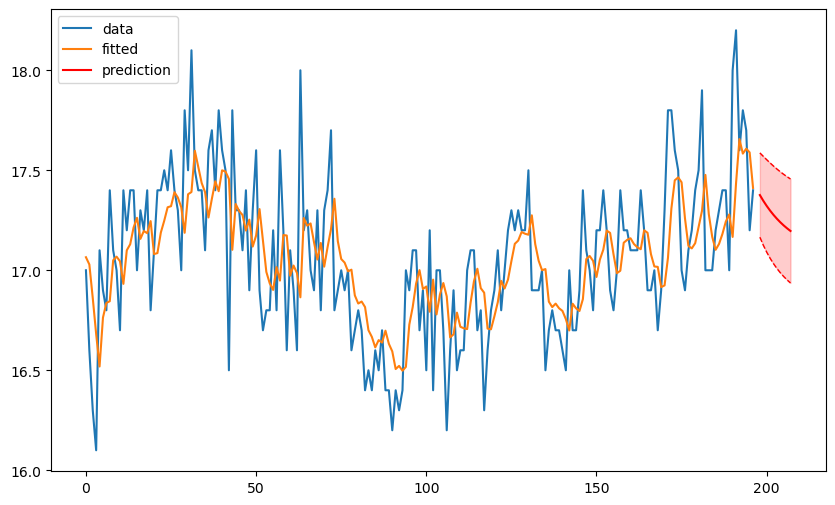

In [13]:
fig = plt.figure(figsize=(10,6))
fig.set_facecolor('white')
 
fitted_values = final_model.fittedvalues ## in-sample prediction
 
## prediction
k = 10
 
forecast = final_model.get_forecast(k) ## out-of-sample prediction
predicted_values = forecast.predicted_mean
prediction_intervals = forecast.conf_int(alpha=0.5)
upper_limit = [x[1] for x in prediction_intervals]
lower_limit = [x[0] for x in prediction_intervals]
 
pred_x = range(len(data)+1, len(data)+k+1)
 
plt.plot(range(len(data)), data, label = 'data')
plt.plot(range(len(data)), fitted_values, label='fitted')
plt.plot(pred_x,predicted_values,color='red',label='prediction')
plt.plot(pred_x,lower_limit,color='red',linestyle='--',linewidth=1)
plt.plot(pred_x,upper_limit,color='red',linestyle='--',linewidth=1)
plt.fill_between(pred_x,lower_limit,upper_limit,color='red',alpha=0.2)
plt.legend()
 
plt.show()
